<a href="https://colab.research.google.com/github/Pumafi/problem_solving_rl_pumafi/blob/main/grid_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
RUNNING_IN_COLAB = True

%cd /content

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/Pumafi/problem_solving_rl_pumafi'
    BRANCH   = 'main'
    REPO_DIR = 'problem_solving_rl_pumafi'

    from pathlib import Path

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}

    %cd {REPO_DIR}

/content
Cloning into 'problem_solving_rl_pumafi'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 17.98 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/problem_solving_rl_pumafi


In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np

import random
import math
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib import colors


from scipy.stats import kde
from sklearn.metrics.pairwise import euclidean_distances

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [3]:
# Load code from the repo
from utils.data_handling import get_color_map, pad_to_shape, preprocess_challenge_data
from utils.preprocess_metalearning_data import filter_and_split_inputs
from models.autoencoder import AutoEncoder

In [4]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

training_challenges = load_json('./data/arc-agi_training_challenges.json')
training_solutions = load_json('./data/arc-agi_training_solutions.json')
evaluation_challenges = load_json('./data/arc-agi_evaluation_challenges.json')

print("Data loaded successfully.")
print(f"Training tasks: {len(training_challenges)}")
print(f"Evaluation tasks: {len(evaluation_challenges)}")

Data loaded successfully.
Training tasks: 400
Evaluation tasks: 400


In [5]:
# all inputs for meta learning, then the training data for latter
challenge_propositioner_inputs, _, _, _, _ = preprocess_challenge_data(training_challenges, training_solutions)
print(len(challenge_propositioner_inputs))

400


In [6]:
# In order of access we have:
#     challenge_propositioner_inputs [problem_nb (list)] [example_nb (list)] [0/1 - input/output (tuple)] -> [30, 30, 10] (ndarray)

# Visualize the size of examples sets (NB: All have at least 2 examples, but 2 is to few for my idea)
for i in range(5):
  print("Problem nb ", i +1, " | nb examples: ", len(challenge_propositioner_inputs[i]))

print("\nSize of one grid: ", challenge_propositioner_inputs[0][0][0].shape)

Problem nb  1  | nb examples:  5
Problem nb  2  | nb examples:  5
Problem nb  3  | nb examples:  3
Problem nb  4  | nb examples:  2
Problem nb  5  | nb examples:  3

Size of one grid:  (30, 30, 10)


In [7]:
flattened_challenges = [
    x
    for xss in challenge_propositioner_inputs
    for xs in xss
    for x in xs
]

flattened_challenges = np.array(flattened_challenges)

print(flattened_challenges.shape)

(2604, 30, 30, 10)


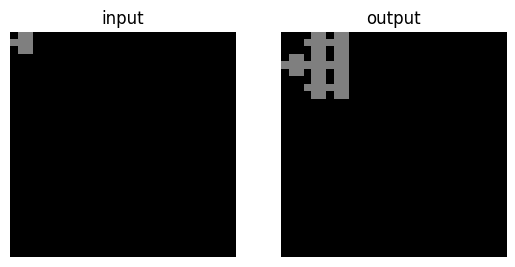

In [8]:
cmap, norm = get_color_map(number_of_categories=9)

plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('output')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.show()

In [9]:
#NB: for this and place cell, get inspiration from GANs, variational distance for Kozachenko-Leonenko, as well as initializing the ccenter of massesf

autoencoder = AutoEncoder()
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss=losses.CategoricalCrossentropy())
autoencoder.build([None, flattened_challenges.shape[1], flattened_challenges.shape[2], 10])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [10]:
encoded_imgs = autoencoder.encoder(flattened_challenges[:2]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs[:2]).numpy()

In [11]:
autoencoder.encoder.load_weights("weights/weigts-encoder.weights.h5")
autoencoder.decoder.load_weights("weights/weigts-decoder.weights.h5")

In [12]:
encoded_imgs = autoencoder.encoder(flattened_challenges[:11]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs[:11]).numpy()

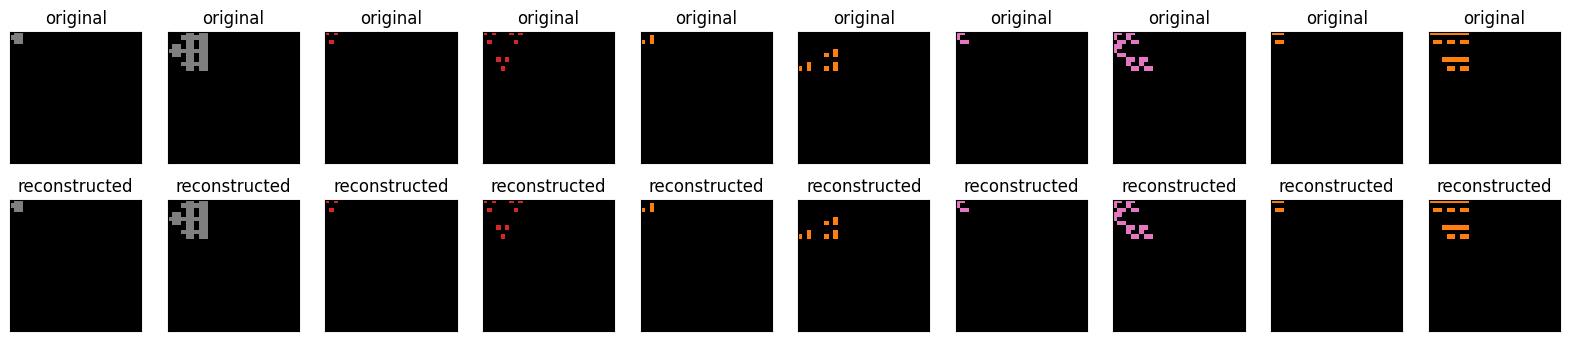

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.argmax(flattened_challenges[i], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
  plt.title("original")
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(np.argmax(decoded_imgs[i], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
  plt.title("reconstructed")
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Move Enconding

In [33]:
def generate_random_move(batch_size):
    position_x = np.random.randint(0, 30, (batch_size, 1))
    position_y = np.random.randint(0, 30, (batch_size, 1))
    n_values = 30
    position_x = np.squeeze(np.eye(n_values)[position_x])

    n_values = 30
    position_y = np.squeeze(np.eye(n_values)[position_y])

    move = np.random.randint(0, 10, (batch_size, 1))
    n_values = 10
    move = np.squeeze(np.eye(n_values)[move])
    return move, position_x, position_y

In [76]:
batch_size = 5

move, position_x, position_y = generate_random_move(batch_size)

print(position_x.shape, move.shape)

(5, 30) (5, 10)


In [77]:
import tensorflow as tf

# Do a wrapper and apply using a mapping

def apply_move(grid, move, position_x, position_y):
    position_x = tf.argmax(position_x, axis=-1)
    position_y = tf.argmax(position_y, axis=-1)
    grid_modified = tf.identity(grid)
    print(grid.dtype, grid_modified.dtype, move.dtype)
    move = tf.cast(move, tf.float32)
    move = tf.cast(grid_modified, tf.float32)
    print(move.shape, grid_modified.shape)
    grid_modified = tf.tensor_scatter_nd_update(grid_modified, [position_x, position_y], move)
    return grid_modified, move, position_x, position_y

def apply_move_wrapper(grid, move, position_x, position_y):
    #grid_modified,_, _, _ =
    tf.map_fn(lambda x: apply_move(x[0], x[1], x[2], x[3]), (grid, move, position_x, position_y))
    return None #grid_modified

In [78]:
import tensorflow as tf

# Function to apply move on a single instance
def apply_move(grid, move, position_x, position_y):
    position_x = tf.argmax(position_x, axis=-1)
    position_y = tf.argmax(position_y, axis=-1)

    grid_modified = tf.identity(grid)

    move = tf.cast(move, tf.float32)
    grid_modified = tf.cast(grid_modified, tf.float32)


    # Ensure indices are correctly shaped
    indices = tf.stack([[position_x, position_y]], axis=0)  # Shape (1, 2)

    # Apply the move
    grid_modified = tf.tensor_scatter_nd_update(grid_modified, indices, [move])

    return grid_modified, move, position_x, position_y

# Wrapper function for batch processing
def apply_move_wrapper(grid, move, position_x, position_y):
    grid_modified = tf.map_fn(lambda x: apply_move(x[0], x[1], x[2], x[3])[0],
                              (grid, move, position_x, position_y), dtype=tf.float32)
    return grid_modified


In [79]:
grid_modified = apply_move_wrapper(flattened_challenges[:batch_size], move, position_x, position_y)

In [80]:
print(position_x.shape, move.shape)

(5, 30) (5, 10)


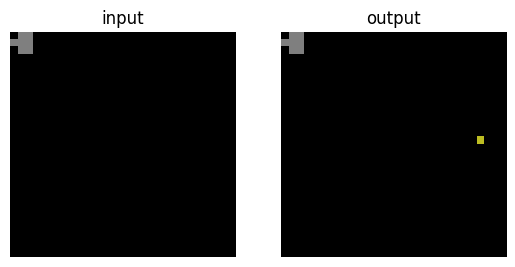

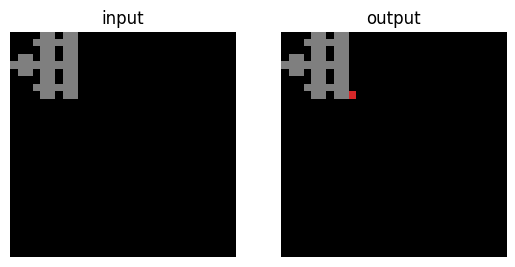

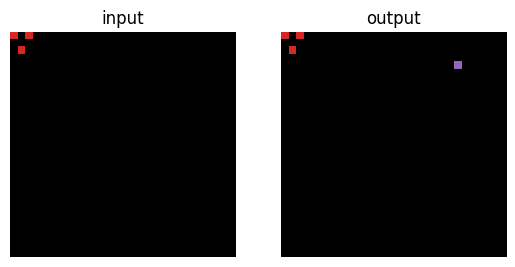

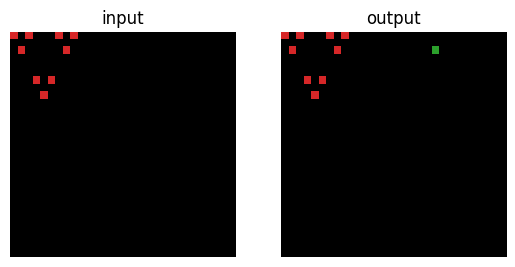

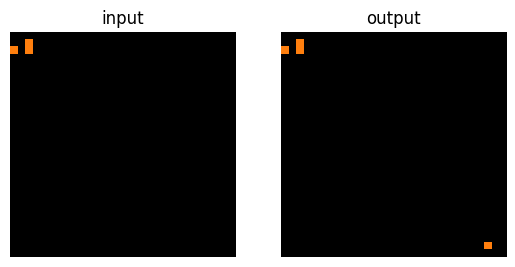

In [81]:
for i in range(5):
    cmap, norm = get_color_map(number_of_categories=9)

    plt.subplot(1, 2, 1)
    plt.title('input')
    plt.imshow(np.argmax(flattened_challenges[i], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('output')
    plt.imshow(np.argmax(grid_modified[i], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    plt.show()

## Grid Cell Machines

In [106]:
import random

latent_dim = 256

class GridLikeEncoding(Model):
    def __init__(self, encoder, batch_size=32):
      super(GridLikeEncoding, self).__init__()

      self.move_encoding = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())
      self.position_encoding = layers.Dense(32, activation=tf.keras.layers.LeakyReLU())
      self.pos_move_concat = layers.Concatenate(axis=-1)


      self.conv = layers.Conv2D(32, (3, 3), activation='swish', padding='same', strides=2)
      self.flat = layers.Flatten()
      self.visual_1 = layers.Dense(256, activation=tf.keras.layers.LeakyReLU())
      self.visual_2 = layers.Dense(128, activation=tf.keras.layers.LeakyReLU())


      self.input_concat = layers.Concatenate(axis=-1)
      self.input_encoding = layers.Dense(256, activation=tf.keras.layers.LeakyReLU())
      self.lstm = keras.layers.LSTM(256)
      self.grid_encoder = layers.Dense(512, activation=tf.keras.layers.LeakyReLU())
      self.grid_layer = layers.Dense(1024, activation='sigmoid')

      self.encoder = encoder
      self.encoder.trainable = False

      self.nb_moves_train = 10
      self.batch_size = batch_size

      self.gridlike_encoder = tf.keras.Sequential([
        layers.Input(shape=(1024,)),
        layers.Dense(1024, activation=tf.keras.layers.LeakyReLU()),
        layers.Dropout(0.1),
        layers.Dense(1024, activation=tf.keras.layers.LeakyReLU()),
        layers.Dense(512, activation=tf.keras.layers.LeakyReLU()),
        layers.Dropout(0.1),
        layers.Dense(512, activation=tf.keras.layers.LeakyReLU()),
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU()),
        layers.Dropout(0.1),
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU()),
        layers.Dense(latent_dim, activation=tf.keras.layers.LeakyReLU()),])


    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker,]

    def call(self, inputs):
        move_input, position_input, visual_input = inputs

        move_encoded = self.move_encoding(move_input)
        position_encoded = self.position_encoding(position_input)
        pos_move_encoded = self.pos_move_concat([move_encoded, position_encoded])

        visual_encoded = self.conv(visual_input)
        visual_encoded = self.flat(visual_encoded)
        visual_encoded = self.visual_1(visual_encoded)
        visual_encoded = self.visual_2(visual_encoded)

        combined_input = self.input_concat([pos_move_encoded, visual_encoded])
        input_encoded = self.input_encoding(combined_input)

        lstm_out = self.lstm(tf.expand_dims(input_encoded, axis=1))

        grid_encoded = self.grid_encoder(lstm_out)
        grid_out = self.grid_layer(grid_encoded)

        latent_representation = self.gridlike_encoder(grid_out)

        return latent_representation

    def train_step(self, input_grids):

        grid_modified = input_grids
        moves = []
        positions = []
        historic = [input_grids, ]

        for i in range(self.nb_moves_train):
            move, position_x, position_y = generate_random_move(self.batch_size)
            moves.append(move)
            positions.append(np.concatenate([position_x, position_y], axis=-1))
            grid_modified = apply_move_wrapper(grid_modified, move, position_x, position_y)
            historic.append(grid_modified)

        ground_truth_encoding = self.encoder(grid_modified)

        moves = np.array(moves)
        positions= np.array(positions)

        y = input_grids
        with tf.GradientTape() as tape:
            for i in range(self.nb_moves_train):
                visual = historic[i] if random.randint(0, 100) <= 10 else tf.zeros_like(historic[i])
                y = self.call([moves[i], positions[i], visual])
            loss = self.loss(ground_truth_encoding, y)

        gradients_model = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients_model, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, input_grids):

        grid_modified = input_grids
        moves = []
        positions = []
        historic = [input_grids, ]

        for i in range(self.nb_moves_train):
            move, position_x, position_y = generate_random_move(self.batch_size)
            moves.append(move)
            positions.append(np.concatenate([position_x, position_y], axis=-1))
            grid_modified = apply_move_wrapper(grid_modified, move, position_x, position_y)
            historic.append(grid_modified)

        ground_truth_encoding = self.encoder(grid_modified)

        moves = np.array(moves)
        positions= np.array(positions)

        y = input_grids
        for i in range(self.nb_moves_train):

            visual = historic[i] if random.randint(0, 100) <= 10 else tf.zeros_like(historic[i])

            y = self.call([moves[i], positions[i], visual])
        loss = self.loss(ground_truth_encoding, y)

        self.loss_tracker.update_state(loss)
        return {m.name: m.result() for m in self.metrics}

In [107]:
gridlike_model = GridLikeEncoding(autoencoder.encoder)

In [108]:
gridlike_model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss=losses.MeanSquaredError())
gridlike_model.build([None, flattened_challenges.shape[1], flattened_challenges.shape[2], 10])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'grid_like_encoding_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [109]:
batch_size = 5
move, position_x, position_y = generate_random_move(batch_size)
position = np.concatenate([position_x, position_y], axis=-1)
gridlike_model.call([move, position, flattened_challenges[:batch_size]])

<tf.Tensor: shape=(5, 256), dtype=float32, numpy=
array([[ 0.00622227, -0.00143476,  0.10779781, ...,  0.02414847,
         0.1571708 , -0.0405066 ],
       [ 0.00672287, -0.00135358,  0.1081963 , ...,  0.0241795 ,
         0.15719162, -0.04061355],
       [ 0.00620278, -0.00135303,  0.10777045, ...,  0.02401191,
         0.15720253, -0.04041557],
       [ 0.00599228, -0.0015014 ,  0.10800695, ...,  0.02416752,
         0.15701607, -0.04041313],
       [ 0.00648571, -0.00145908,  0.10781217, ...,  0.02384714,
         0.15731333, -0.04046643]], dtype=float32)>

In [110]:
flattened_challenges.shape

(2604, 30, 30, 10)

In [111]:
history = gridlike_model.fit(flattened_challenges,
                             epochs=100,
                             batch_size=32,
                             shuffle=True,
                             validation_split=0.2)

Epoch 1/100


ValueError: Dimensions must be equal, but are 15 and 32 for '{{node mean_squared_error/sub}} = Sub[T=DT_FLOAT](sequential_1/dense_6_1/leaky_re_lu_6_1/LeakyRelu, sequential_6_19/dense_83_1/leaky_re_lu_78_1/LeakyRelu)' with input shapes: [?,15,15,256], [32,256].